In [199]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymdp
from pymdp import utils

# O, S, U

In [201]:
n_action = 10

In [202]:
# Sales states (how much has been sold)
Sales_1 =  np.arange(0, n_action)
Sales_2 =  np.arange(0, n_action)

# Market states (if I have produced enaugh or not)
Market_1 = ['Produced excess', 'Not exceded']
Market_2 = ['Produced excess', 'Not exceded']

# number of states
n_states_1 = [len(Sales_1), len(Market_1)]
n_states_2 = [len(Sales_2), len(Market_2)]

# number of factors
n_factors_1 = len(n_states_1) 
n_factors_2 = len(n_states_2)

# actions
Production_1 =  np.arange(0, n_action)
Production_2 =  np.arange(0, n_action)

satisfy_market_action = ['Market survey'] # OK, si potrebbe aggiungere la scelta di non fare il market survey, magari farlo ha costo, prima però facciamo
                                          # funzionare il caso base

num_controls_1 = [len(Production_1), len(satisfy_market_action)]
num_controls_2 = [len(Production_2), len(satisfy_market_action)]

# observations of sales and market observations (satisfied costumer demand or not)
obs_sales_1 = np.arange(0, n_action)
obs_sales_2 = np.arange(0, n_action)

obs_market_1 = ['Exceded', 'Not exceded'] 
obs_market_2 = ['Exceded', 'Not exceded']

# number of observations and modalities
num_obs_1 = [len(obs_sales_1), len(obs_market_1)]
num_obs_2 = [len(obs_sales_2), len(obs_market_2)]

num_modalities_1 = len(num_obs_1) 
num_modalities_2 = len(num_obs_2)

# A

In [203]:
A1 = utils.obj_array(num_modalities_1)
A2 = utils.obj_array(num_modalities_2)

## sales

In [204]:
# Sales obs x State Sales x State Market
A1_sales = np.zeros((len(obs_sales_1), len(Sales_1), len(Market_1)))
A2_sales = np.zeros((len(obs_sales_2), len(Sales_2), len(Market_2)))

for k in range(len(Market_1)):
    np.fill_diagonal(A1_sales[:, :, k], 1)

for k in range(len(Market_2)):
    np.fill_diagonal(A2_sales[:, :, k], 1)

A1[0] = A1_sales
A2[0] = A2_sales

## market

In [205]:
A1_market = np.zeros((len(obs_market_1), len(Sales_1), len(Market_1)))
A2_market = np.zeros((len(obs_market_2), len(Sales_2), len(Market_2)))

trust_market = 1.0 # 1 means perfect trust
# NB: per come sono fatte le cose al momento non ha senso !=1

# Assign perception probabilities for updated market size
A1_market[0, :, 0] = trust_market           # exceeded <- produced excess
A1_market[1, :, 0] = (1 - trust_market)     # satisfied <- produced excess
A1_market[0, :, 1] = (1 - trust_market)     
A1_market[1, :, 1] = trust_market           # satisfied <- produced satisfied demand

A2_market[0, :, 0] = trust_market
A2_market[1, :, 0] = (1 - trust_market)
A2_market[0, :, 1] = (1 - trust_market)
A2_market[1, :, 1] = trust_market

A1[1] = A1_market
A2[1] = A2_market

# B

In [206]:
B1 = utils.obj_array(n_factors_1)
B2 = utils.obj_array(n_factors_2)

# sales

In [207]:
B1_sales = np.zeros((len(Sales_1), len(Sales_1), len(Production_1)))
B2_sales = np.zeros((len(Sales_2), len(Sales_2), len(Production_2)))

#I can sell as much as I produce (potentially) independently from previous sales
for i in range(len(Production_1)):
    for end_state in range(len(Production_1)):
        if end_state <= i:
            B1_sales[end_state, :, i] = 1/(i+1)

#completing agent2 transition matrix
for i in range(len(Production_2)):
    for end_state in range(len(Production_2)):
        if end_state <= i:
            B2_sales[end_state, :, i] = 1/(i+1)

B1[0] = B1_sales
B2[0] = B2_sales

## market

In [208]:
B1_market = np.zeros((len(Market_1), len(Market_1), len(satisfy_market_action)))
B2_market = np.zeros((len(Market_2), len(Market_2), len(satisfy_market_action)))

B1_market[:,:,0] = np.full((len(Market_1), len(Market_1)), 1/2) 
B2_market[:,:,0] = np.full((len(Market_1), len(Market_1)), 1/2)

B1[1] = B1_market
B2[1] = B2_market

# C

In [209]:
C1 = utils.obj_array_zeros(num_obs_1)
C2 = utils.obj_array_zeros(num_obs_2)

## Profit

In [210]:
assumed_market_price_1 = 10 # earning from a single piece
production_cost_1 = 5 # price of a single piece
discount_rate_1 = np.ones(len(Production_1)) #np.array([1, 1, 0.9, 0.8, 0.7, 0.6]) # the more I produce the less I pay

assumed_market_price_2 = 10 # earning from a single piece
production_cost_2 = 5 # price of a single piece
discount_rate_2 = np.ones(len(Production_2)) # the more I produce the less I pay

In [211]:
def gain(market_price, prod_cost, n_sells, Production):
    C_gain = (market_price-prod_cost)*Production - np.maximum(0,(Production-n_sells))*market_price
    return C_gain

In [ ]:
def gain_SRP(SRP_model, prod_cost, n_sells, Production, production_competitor):
    # Assume Production is a numpy array of production levels
    gains = []
    for prod in Production:
        # Create a feature dictionary for each instance.
        # Adjust the key names according to your feature naming.
        instance = {
            'prod_1': prod,
            'prod_2': production_competitor,
        }
        # Predict the market price for this instance.
        predicted_price = SRP_model.predict_one(instance)
        # Compute the gain for this production level.
        c_gain = (predicted_price - prod_cost) * prod - np.maximum(0, (prod - n_sells)) * predicted_price #!!!!
        gains.append(c_gain)
    return np.array(gains)

In [213]:
C_gain_1 = gain(market_price=assumed_market_price_1, prod_cost=production_cost_1, n_sells=max(Production_1), Production=Production_1)
C_gain_2 = gain(market_price=assumed_market_price_2, prod_cost=production_cost_2, n_sells=max(Production_2), Production=Production_2)

C1[0] = C_gain_1
C2[0] = C_gain_2

### SRP function for Pricing regression

In [214]:
from river.metrics.base import Metrics
from river.metrics import RMSE
from river.preprocessing import StandardScaler
from river.drift import ADWIN

In [215]:
from river.ensemble import SRPRegressor
from river.tree import HoeffdingTreeRegressor

SRP = (StandardScaler() |
        SRPRegressor(
            n_models=10,
            seed=1,
            drift_detector=ADWIN(delta=0.001),
            warning_detector=ADWIN(delta=0.01),
            model = HoeffdingTreeRegressor(
                grace_period=50,
                leaf_prediction='adaptive',
                model_selector_decay=0.9,                
            )            
        ))
SRP_mse = Metrics(metrics=[RMSE()])

## market

In [216]:
C1_market = np.zeros(len(obs_market_1))
C1[1] = C1_market

C2_market = np.zeros(len(obs_market_2))
C2[1] = C2_market

# D

In [217]:
D1 = utils.obj_array(n_factors_1)
D2 = utils.obj_array(n_factors_2)

# Sales state prior
D1[0] = np.full(len(Sales_1), 1 / len(Sales_1))
D2[0] = np.full(len(Sales_2), 1 / len(Sales_2))

# Market state prior
D1[1] = np.full(len(Market_1), 1 / len(Market_1))
D2[1] = np.full(len(Market_2), 1 / len(Market_2))

# Agent

In [218]:
B1_prior = utils.dirichlet_like(B1)
B2_prior = utils.dirichlet_like(B2)

In [219]:
from pymdp.agent import Agent

my_agent1 = Agent(A = A1, B = B1, C = C1, D = D1, policy_len=1,
                    use_states_info_gain = False, #True di default
                    use_param_info_gain = False, #False di default
                    num_controls = num_controls_1, 
                    action_selection='stochastic', alpha = 0.15, 
                    pA = None, lr_pA=1.0, modalities_to_learn="all",
                    pB = B1_prior, lr_pB=0.5, pD = None, lr_pD=1.0, factors_to_learn='all')
my_agent2 = Agent(A = A2, B = B2, C = C2, D = D2, policy_len=1,
                    use_states_info_gain = False, #True di default
                    use_param_info_gain = False, #False di default
                    num_controls = num_controls_2, 
                    action_selection='stochastic', alpha = 0.15,
                    pA = None, lr_pA=1.0, modalities_to_learn="all",
                    pB = B1_prior, lr_pB=0.5, pD = None, lr_pD=1.0, factors_to_learn='all')

# Environment

In [220]:
class CournotMarket(object):

    def __init__(self, reputation=0.5, total_demand=5, max_customer_price=10, sensibility=1):
        self.reputation = float(reputation)
        self.total_demand = float(total_demand)
        self.max_customer_price = float(max_customer_price)
        self.sensibility = float(sensibility)
        self.market_obs_names = ['Satisfied', 'Exceded', 'Unsatisfied']
    
    def market_status(self, actual_production, preferred_demand):
        if actual_production > preferred_demand:
            return 'Exceded'
        else:
            return 'Not exceded'

    def step(self, action1, action2):
        total_production = action1[0] + action2[0]
        
        market_price = max(0, self.max_customer_price - self.sensibility * total_production)
        
        preferred_demand_1 = int(self.total_demand * self.reputation)
        preferred_demand_2 = self.total_demand - preferred_demand_1
        
        actual_sales_1 = min(action1[0], preferred_demand_1)
        actual_sales_2 = min(action2[0], preferred_demand_2)
        
        remaining_demand_1 = preferred_demand_1 - actual_sales_1
        remaining_demand_2 = preferred_demand_2 - actual_sales_2
        
        if remaining_demand_1 > 0 and action2[0] > actual_sales_2:
            extra_sales_2 = min(action2[0] - actual_sales_2, remaining_demand_1)
            actual_sales_2 += extra_sales_2
            remaining_demand_1 -= extra_sales_2
        
        if remaining_demand_2 > 0 and action1[0] > actual_sales_1:
            extra_sales_1 = min(action1[0] - actual_sales_1, remaining_demand_2)
            actual_sales_1 += extra_sales_1
            remaining_demand_2 -= extra_sales_1
        
        obs_prod = [int(action1[0]), int(action2[0])]
        obs_sales = [int(actual_sales_1), int(actual_sales_2)] 
        obs_market = [self.market_status(action1[0], preferred_demand_1),
                      self.market_status(action2[0], preferred_demand_2)]
        return obs_prod, obs_sales, obs_market, market_price

# Loop

In [221]:
prod1 = []
prod2 = []

sold1 = []
sold2 = []

real_price =[]
predicted_price = []

Belief_gain1 =[]
real_gain1 = []
BR1_real_gain = []

Belief_gain2 =[]    
real_gain2 = []
BR2_real_gain = []

In [ ]:
def run_active_inference_loop(my_agent1, my_agent2, my_env, BR_1, BR_2, T=5, 
                              initial_alpha=0.05, final_alpha=0.2):
    """Runs an active inference loop where alpha increases over time."""

    market_label = ['Exceded', 'Not exceded']
    obs1 = [0, obs_market_1.index(market_label[0])] 
    obs2 = [0, obs_market_2.index(market_label[0])]

    for t in range(T):
        # Linear schedule for alpha increase
        alpha_range = final_alpha - initial_alpha
        my_agent1.alpha = initial_alpha + (alpha_range * t / (T - 1))
        my_agent2.alpha = initial_alpha + (alpha_range * t / (T - 1))

        # Agents infer hidden states
        qs_1 = my_agent1.infer_states(obs1)
        qs_2 = my_agent2.infer_states(obs2)

        # Infer policies
        q_pi_1, efe_1 = my_agent1.infer_policies()
        q_pi_2, efe_2 = my_agent2.infer_policies()

        # Sample actions based on stochastic policy selection
        action_1 = my_agent1.sample_action()
        action_2 = my_agent2.sample_action()

        # Environment step
        obs_prod, obs_sales, obs_market, market_price = my_env.step(action_1, action_2)
        BR1_prod, BR1_obs_sales, BR1_obs_market, BR1_market_price = my_env.step([round(BR_1)], action_2)
        BR2_prod,BR2_obs_sales, BR1_obs_market, BR2_market_price = my_env.step(action_1, [round(BR_2)])

        instance = {f"prod_{i}": v for i, v in enumerate(obs_prod)}

        price_hat = SRP.predict_one(instance)
        SRP.learn_one(instance, market_price)

        # Update preference distribution (C matrix) using a custom gain function
        my_agent1.C[0] = gain_SRP(SRP, prod_cost=production_cost_1, n_sells=obs_sales[0], 
                                  Production=Production_1, production_competitor=action_2[0])
        my_agent2.C[0] = gain_SRP(SRP, prod_cost=production_cost_2, n_sells=obs_sales[1], 
                                  Production=Production_2, production_competitor=action_1[0])

        # Update observations
        obs1 = [obs_sales[0], obs_market_1.index(obs_market[0])]
        obs2 = [obs_sales[1], obs_market_2.index(obs_market[1])]

        prod1.append(action_1[0])
        prod2.append(action_2[0])

        sold1.append(obs_sales[0])
        sold2.append(obs_sales[1])

        predicted_price.append(price_hat)
        real_price.append(market_price)

        Belief_gain1.append(my_agent1.C[0][int(action_1[0])])
        real_gain1.append(gain(market_price=market_price, prod_cost=production_cost_1, n_sells=obs_sales[0], Production=action_1[0]))
        BR1_real_gain.append(gain(market_price=BR1_market_price, prod_cost=production_cost_1, n_sells=BR1_obs_sales[0], Production=round(BR_1)))

        Belief_gain2.append(my_agent2.C[0][int(action_2[0])])
        real_gain2.append(gain(market_price=market_price, prod_cost=production_cost_2, n_sells=obs_sales[1], Production=action_2[0]))
        BR2_real_gain.append(gain(market_price=BR2_market_price, prod_cost=production_cost_2, n_sells=BR2_obs_sales[1], Production=round(BR_2)))

        # C_diff = my_agent1.C[0] - C_real
        # print(f'Diff C: {C_diff}')


        # print("C1 = ", my_agent1.C, "markt price = ", market_price)
        # print("C2 = ", my_agent2.C, "markt price = ", market_price)
        # print(f'Production industry 1 at time {t}: {action_1[0]}')
        # print(f'Production industry 2 at time {t}: {action_2[0]}') 
        # print(f'Sells of industries at time {t}: {obs_sales}')
        # print(f'Market at time {t}: {obs_market}')


# Main

In [223]:
import warnings
warnings.filterwarnings('ignore')

In [224]:
max_customer_price = 20
sensibility = 1
BR_1 = min(max(Production_1), (max_customer_price - 2 * production_cost_1 + production_cost_2) / (3*sensibility))
BR_2 = min(max(Production_2), (max_customer_price - 2 * production_cost_2 + production_cost_1) / (3*sensibility))
print(f'Best response for industry 1: {BR_1}')
print(f'Best response for industry 2: {BR_2}')

Best response for industry 1: 5.0
Best response for industry 2: 5.0


In [225]:
reputation_env = 0.5
total_demand_env = 12
env = CournotMarket(reputation = reputation_env, total_demand = total_demand_env, max_customer_price = max_customer_price, sensibility = sensibility)

T = 50

run_active_inference_loop(my_agent1, my_agent2, env, BR_1 = BR_1, BR_2 = BR_2, T = T)

# Plot

In [226]:
time = np.arange(T)

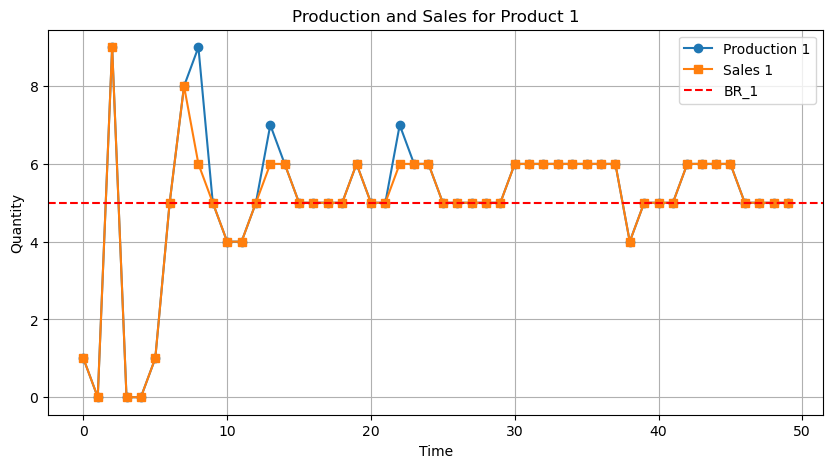

In [227]:
# 1) Plot di prod1 e sold1 nel tempo
plt.figure(figsize=(10, 5))
plt.plot(time, prod1, label='Production 1', marker='o')
plt.plot(time, sold1, label='Sales 1', marker='s')
plt.axhline(y=BR_1, color='r', linestyle='--', label='BR_1')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.title('Production and Sales for Product 1')
plt.legend()
plt.grid()
plt.show()

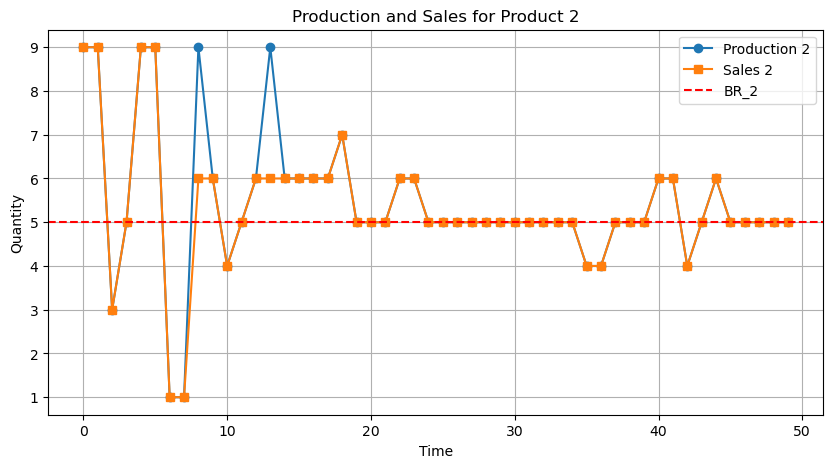

In [228]:
# 2) Plot di prod2 e sold2 nel tempo
plt.figure(figsize=(10, 5))
plt.plot(time, prod2, label='Production 2', marker='o')
plt.plot(time, sold2, label='Sales 2', marker='s')
plt.axhline(y=BR_2, color='r', linestyle='--', label='BR_2')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.title('Production and Sales for Product 2')
plt.legend()
plt.grid()
plt.show()

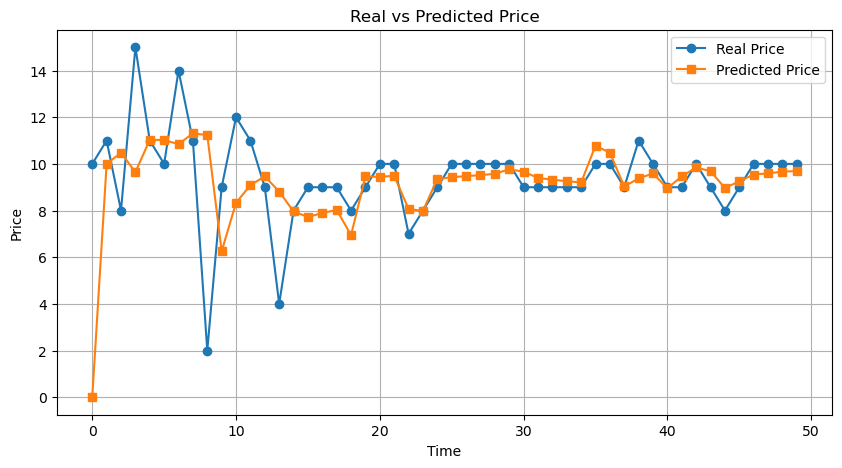

In [229]:
# 3) Andamento di real_price e predicted_price nel tempo
plt.figure(figsize=(10, 5))
plt.plot(time, real_price, label='Real Price', marker='o')
plt.plot(time, predicted_price, label='Predicted Price', marker='s')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Real vs Predicted Price')
plt.legend()
plt.grid()
plt.show()

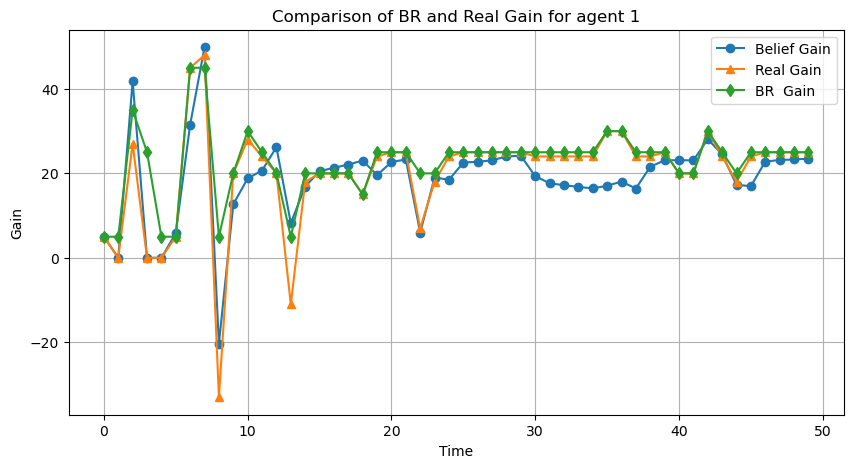

In [230]:
# 4) Andamento di belief_gain, BR_belief_gain, real_gain, BR_real_gain nel tempo
plt.figure(figsize=(10, 5))
plt.plot(time, Belief_gain1, label='Belief Gain', marker='o')
# plt.plot(time, BR_belief_gain, label='BR Belief Gain', marker='s')
plt.plot(time, real_gain1, label='Real Gain', marker='^')
plt.plot(time, BR1_real_gain, label='BR  Gain', marker='d')
plt.xlabel('Time')
plt.ylabel('Gain')
plt.title('Comparison of BR and Real Gain for agent 1')
plt.legend()
plt.grid()
plt.show()

La BR non tiene conto delle possibili dinamiche tra i giocatori

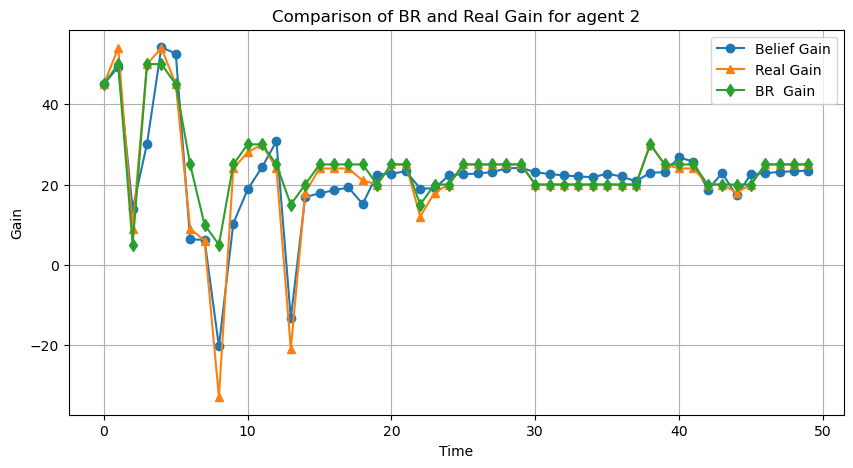

In [231]:
plt.figure(figsize=(10, 5))
plt.plot(time, Belief_gain2, label='Belief Gain', marker='o')
# plt.plot(time, BR_belief_gain, label='BR Belief Gain', marker='s')
plt.plot(time, real_gain2, label='Real Gain', marker='^')
plt.plot(time, BR2_real_gain, label='BR  Gain', marker='d')
plt.xlabel('Time')
plt.ylabel('Gain')
plt.title('Comparison of BR and Real Gain for agent 2')
plt.legend()
plt.grid()
plt.show()